# Nanobot Defect Classification Model

Classify atomic lattice defects from microscopy/simulation image patches and localize them on larger 512×512 images.

This notebook builds a **two-stage CNN pipeline** trained on **64×64 patches**:
- **Stage 1 (Binary):** `Normal vs Defect`
- **Stage 2 (Multiclass):** `Antisite vs Vacancy vs Interstitial` (only on defect patches)

Finally, because large images are 512×512 while the model is trained on 64×64, we perform **sliding-window inference** to create **pixel-level probability heatmaps** and draw **contours + bounding boxes** around predicted defect regions.


## Why a Two-Stage Pipeline?
Direct 4-class training (Normal + 3 defect types) often struggles due to:
- **Class imbalance** (Normal dominates, some defect types are rare)
- **Domain shift** (defect patterns can vary subtly between samples)
- **High confusion** between defect types when the model is unsure

So we split the task:
1. Stage 1 learns a strong separation of *Normal vs Anything unusual*
2. Stage 2 focuses only on defect images and learns defect-type boundaries better



## Input Representation: Raw + FFT (2 channels)
Each 64×64 patch is converted into a 2-channel tensor:
- **Channel 0:** spatial image (normalized + light smoothing)
- **Channel 1:** FFT magnitude (log-scaled / normalized)

The FFT channel helps capture changes in **periodicity** and **lattice regularity** that are hard to see in the spatial domain alone.


## Execution Roadmap

1. **Setup & configuration**
2. **Preprocessing**
   - Read grayscale PNG
   - Build 2-channel input (Raw + FFT)
3. **Stage 1 Training**
   - Build Normal vs Defect dataset
   - Train CNN + evaluate with confusion matrix
4. **Stage 2 Training**
   - Build defect-only dataset
   - Augmentation + semi-balanced sampling
   - Train CNN + evaluate with confusion matrix
5. **512×512 Localization**
   - Sliding-window scanning (64×64 stride S)
   - Stage 1 filters candidate defect patches
   - Stage 2 predicts defect type probabilities
   - Merge patch predictions into smooth heatmaps
   - Convert heatmaps into masks + contours + boxes
6. **Results, Learnings, and Future Improvements**


# Step 1: Import the Libraries and Load the data

In [8]:
#Imports
import os, glob, random
# Numerical & scientific computing
import numpy as np
import scipy.ndimage as ndi

# Deep learning
import tensorflow as tf

# Visualization
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

# Evaluation & data splitting
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

# Configuration
DATASET_DIR = "dataset"          # dataset contains Normal, Antisite, Vacancy, interstitial Images
IMG_SIZE    = (64, 64)          # Random seed for reproducibility across NumPy, Python, and TensorFlow
SEED        = 42
# Training hyperparameters
EPOCHS_S1   = 30                 # Stage 1 epochs
EPOCHS_S2   = 30                # Stage 2 epochs (often needs more)
BATCH_SIZE  = 16                # Mini-batch Size for training
AUTOTUNE    = tf.data.AUTOTUNE # TensorFlow performance optimization

# Ensure consistent results across runs
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)


# Step 2: Preprocessing & Utility Functions

- This section handles image loading, preprocessing, and evaluation utilities.
- Each 64×64 patch is converted into a 2-channel representation (Raw + FFT) to capture
both spatial structure and lattice periodicity before model training.


In [9]:
def read_grayscale_png(path: str) -> np.ndarray:
    # Read PNG and convert RGB->grayscale if needed.
    # Returns a 2D Numpy array
    img = plt.imread(path)
    if img.ndim == 3:
        img = img[:, :, 0]
    return img

def preprocess_two_channel(img: np.ndarray) -> np.ndarray:
    """
    Convert a 64×64 image into a 2-channel input:
    - Channel 0: normalized spatial image with light smoothing
    - Channel 1: normalized FFT magnitude (log-scaled)
    """
    img = img.astype(np.float32)
   # Spatial domain normalization + noise suppression
    spatial = img / (np.max(img) + 1e-8)
    spatial = ndi.gaussian_filter(spatial, sigma=0.5)
   # Frequency domain representation (captures lattice periodicity)
    fft = np.fft.fftshift(np.fft.fft2(spatial))
    fft_mag = np.log1p(np.abs(fft))
    fft_mag = (fft_mag - np.mean(fft_mag)) / (np.std(fft_mag) + 1e-8)
    return np.stack([spatial, fft_mag], axis=-1).astype(np.float32)

def load_class(folder: str, label: int):
    """Load all PNGs from a folder and assign the same label."""
    files = sorted(glob.glob(os.path.join(folder, "*.png")))
    X, y = [], []
    for f in files:
        img = read_grayscale_png(f)
        X.append(preprocess_two_channel(img))
        y.append(label)
    print(f"Loaded {len(X)} from {os.path.basename(folder)}")
    return X, y

def eval_and_plot(y_true, y_pred, labels, target_names, title):
    """Print classification metrics and display a confusion matrix."""
    print(classification_report(y_true, y_pred, labels=labels, target_names=target_names, zero_division=0))
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    disp = ConfusionMatrixDisplay(cm, display_labels=target_names)
    disp.plot(cmap="Blues", values_format="d")
    plt.title(title)
    plt.show()


# Step 3 — Stage 1: Normal vs Defect (Binary Classification)

In this stage, a binary CNN is trained to distinguish **Normal** lattice patches from
any type of **Defect**. This separation helps mitigate class imbalance and domain shift,
and produces a sigmoid output representing the probability of a patch being defective.
The model later acts as a filter before defect-type classification.



In [10]:
# Label convention:
# 0 → Normal
# 1 → Defect (Antisite, Vacancy, or Interstitial)

# Load class-wise data
Xn, yn = load_class(os.path.join(DATASET_DIR, "Normal"), 0)
Xa, ya = load_class(os.path.join(DATASET_DIR, "Antisite"), 1)
Xv, yv = load_class(os.path.join(DATASET_DIR, "Vacancy"), 1)
Xi, yi = load_class(os.path.join(DATASET_DIR, "Interstitial"), 1)

# Combine all samples into a single dataset
X = np.array(Xn + Xa + Xv + Xi, dtype=np.float32)
y = np.array(yn + ya + yv + yi, dtype=np.int32)

# Report class distribution
print("Stage-1 Total Counts:", {"normal": int(np.sum(y==0)), "defect": int(np.sum(y==1))})

# Stratified train / validation / test split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.25, random_state=SEED)
X_train, X_val,  y_train, y_val  = train_test_split(X_train, y_train, stratify=y_train, test_size=0.2, random_state=SEED)


Loaded 371 from Normal
Loaded 200 from Antisite
Loaded 43 from Vacancy
Loaded 48 from Interstitial
Stage-1 Total Counts: {'normal': 371, 'defect': 291}


**step 3.1 Stage 1 Model Architecture and Training**

- This CNN is designed to learn a compact representation of lattice patches and
output a single probability indicating whether a patch contains a defect.
- Global Average Pooling is used to reduce overfitting and make the model less
sensitive to exact defect location within the patch.


Epoch 1/30
24/25 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 0.5861 - loss: 0.6789
Epoch 1: val_loss improved from None to 0.93813, saving model to best_model_stage1_binary.keras
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 69ms/step - accuracy: 0.5859 - loss: 0.6734 - val_accuracy: 0.4400 - val_loss: 0.9381 - learning_rate: 0.0010
Epoch 2/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 0.6275 - loss: 0.6378
Epoch 2: val_loss improved from 0.93813 to 0.88365, saving model to best_model_stage1_binary.keras
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 80ms/step - accuracy: 0.6086 - loss: 0.6426 - val_accuracy: 0.4400 - val_loss: 0.8837 - learning_rate: 0.0010
Epoch 3/30
24/25 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.6406 - loss: 0.6481
Epoch 3: val_loss improved from 0.88365 to 0.74853, saving model to best_model_stage1_binary.keras
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 65ms/step - accuracy: 0.6313 - loss: 0.6428 - val_accuracy: 0.4500 - val_loss: 0.7485 - learning_rate: 0.0010
Epoch 4/30
24/25 ━━━━━━━━━━━━━━

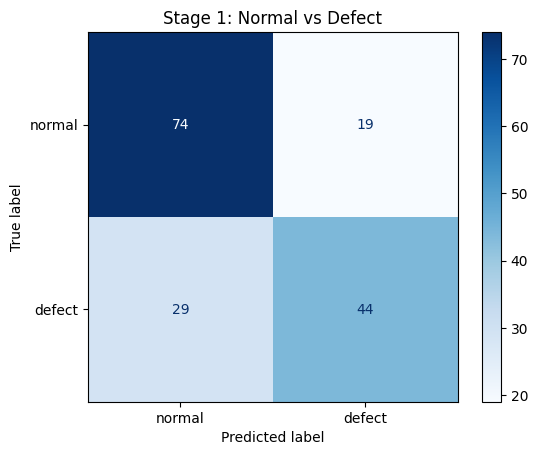

In [11]:
# He initialization for ReLU-based convolution layers
init = tf.keras.initializers.HeNormal()

 #Stage 1: Binary CNN (Normal vs Defect)

stage1 = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(64, 64, 2)), # Raw + FFT channels

  # Convolution block 1
    tf.keras.layers.Conv2D(64, 3, padding="same", kernel_initializer=init),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation("relu"),
    tf.keras.layers.MaxPooling2D(2),

  # Convolution block 2
    tf.keras.layers.Conv2D(128, 3, padding="same", kernel_initializer=init),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation("relu"),

    # Spatial aggregation (location-invariant features)
    tf.keras.layers.GlobalAveragePooling2D(),
    # Fully connected head
    tf.keras.layers.Dense(64, activation="relu"),
    tf.keras.layers.Dropout(0.3),

    tf.keras.layers.Dense(1, activation="sigmoid")  # P(defect)
])
# Compile binary classifier
stage1.compile(optimizer=tf.keras.optimizers.Adam(1e-3),
               loss="binary_crossentropy",
               metrics=["accuracy"])
# Training callbacks for stability and generalization
callbacks = [
    tf.keras.callbacks.ModelCheckpoint("best_model_stage1_binary.keras", monitor="val_loss", save_best_only=True, verbose=1),
    tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=6, restore_best_weights=True, verbose=1),
    tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=2, min_lr=1e-6, verbose=1),
]
# Train Stage 1 model
stage1.fit(X_train, y_train,
           validation_data=(X_val, y_val),
           epochs=EPOCHS_S1,
           batch_size=BATCH_SIZE,
           callbacks=callbacks,
           verbose=1)

# Evaluate
p_def = stage1.predict(X_test).ravel()
preds = (p_def >= 0.5).astype(int)
# Classification metrics and confusion matrix
eval_and_plot(y_test, preds, labels=[0,1], target_names=["normal","defect"], title="Stage 1: Normal vs Defect")


**Result Explanation:** Stage 1 achieved reliable separation between Normal and Defect patches, with strong
performance on Normal samples and moderate overall accuracy (~61%). The model was
intentionally conservative, favoring Normal predictions and reducing false positives,
at the cost of missing some subtle defect cases. This behavior is suitable for a
two-stage pipeline, where Stage 1 acts as a filter before defect-type classification.


##  Step 4: Stage 2 - Defect Type Classification (Antisite vs Vacancy vs Interstitial)

- Stage 2 is trained only on defect patches (Normal is excluded) and predicts the defect type
using the same 2-channel input (Raw + FFT). 
- Light augmentation and semi-balanced sampling
- Helps to improve performance on minority defect classes.



Loaded 200 images from Antisite
Loaded 43 images from Vacancy
Loaded 48 images from interstitial

Stage-2 class counts:
antisite: 200
vacancy : 43
inter   : 48
Total: 291 X shape: (291, 64, 64, 2)

Test label counts: [50 11 12]
Val  label counts: [30  7  7]
Train label counts: [120  25  29]

Train2 sizes: [120, 25, 29]
steps_per_epoch: 100


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_7 (Conv2D)               │ (None, 64, 64, 64)     │         1,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_7 (Activation)       │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_8 (Activation)       │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 16, 16, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 16, 16, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_9 (Activation)       │ (None, 16, 16, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_3      │ (None, 256)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 405,315 (1.55 MB)

 Trainable params: 404,419 (1.54 MB)

 Non-trainable params: 896 (3.50 KB)

Epoch 1/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - accuracy: 0.6345 - loss: 0.9348
Epoch 1: val_loss improved from None to 0.87915, saving model to best_model_stage2_defects.keras
100/100 ━━━━━━━━━━━━━━━━━━━━ 7s 57ms/step - accuracy: 0.6580 - loss: 0.9015 - val_accuracy: 0.6818 - val_loss: 0.8792 - learning_rate: 0.0010
Epoch 2/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 0.7018 - loss: 0.8215
Epoch 2: val_loss did not improve from 0.87915
100/100 ━━━━━━━━━━━━━━━━━━━━ 6s 56ms/step - accuracy: 0.6940 - loss: 0.8331 - val_accuracy: 0.6818 - val_loss: 0.9706 - learning_rate: 0.0010
Epoch 3/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - accuracy: 0.7049 - loss: 0.7968
Epoch 3: val_loss did not improve from 0.87915

Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
100/100 ━━━━━━━━━━━━━━━━━━━━ 6s 55ms/step - accuracy: 0.6840 - loss: 0.8249 - val_accuracy: 0.6818 - val_loss: 0.9826 - learning_rate: 0.0010
Epoch 4/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 57

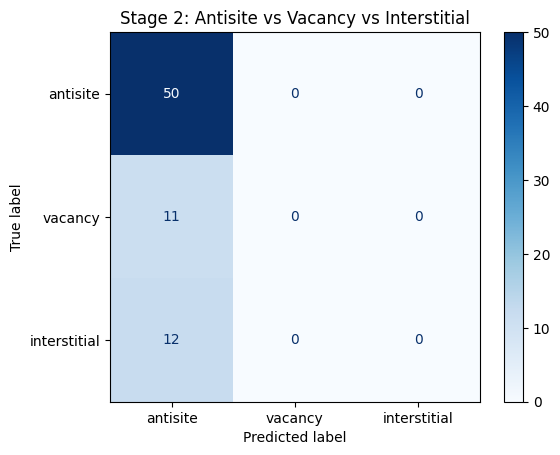

In [12]:
#  Stage 2 CONFIG 
DATASET_DIR = "dataset"
IMG_SIZE = (64, 64)
EPOCHS = 30
BATCH_SIZE = 10
SEED = 42

random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

AUTOTUNE = tf.data.AUTOTUNE
class_names = ["antisite", "vacancy", "interstitial"]   # Stage-2 labels (0,1,2)

# PREPROCESS (RAW + FFT 2-channel) 
def preprocess_two_channel(img):
    img = img.astype(np.float32)
  # Spatial normalization + light smoothing
    spatial = img / (np.max(img) + 1e-8)
    spatial = ndi.gaussian_filter(spatial, sigma=0.5)
 # FFT magnitude captures lattice periodicity shifts
    fft = np.fft.fftshift(np.fft.fft2(spatial))
    fft_mag = np.log1p(np.abs(fft))
    fft_mag = fft_mag / (np.max(fft_mag) + 1e-8)

    return np.stack([spatial, fft_mag], axis=-1).astype(np.float32)

def load_class(folder, label):
    """Load all PNG patches in a folder and assign a fixed label."""
    files = glob.glob(os.path.join(folder, "*.png"))
    X, y = [], []
    for f in files:
        img = plt.imread(f)
        if img.ndim == 3:  # RGB → grayscale 
            img = img[:, :, 0]
        X.append(preprocess_two_channel(img))
        y.append(label)
    print(f"Loaded {len(X)} images from {os.path.basename(folder)}")
    return X, y

#Load Defect-only dataset
antisite_X, antisite_y = load_class(os.path.join(DATASET_DIR, "Antisite"), 0)
vacancy_X, vacancy_y   = load_class(os.path.join(DATASET_DIR, "Vacancy"), 1)
inter_X, inter_y       = load_class(os.path.join(DATASET_DIR, "interstitial"), 2)

X = np.array(antisite_X + vacancy_X + inter_X, dtype=np.float32)
y = np.array(antisite_y + vacancy_y + inter_y, dtype=np.int32)

print("\nStage-2 class counts:")
print("antisite:", len(antisite_X))
print("vacancy :", len(vacancy_X))
print("inter   :", len(inter_X))
print("Total:", len(X), "X shape:", X.shape)

assert len(X) > 0, "No defect images found"

## Stratified train/val/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.25, random_state=SEED
)
X_train2, X_val, y_train2, y_val = train_test_split(
    X_train, y_train, stratify=y_train, test_size=0.2, random_state=SEED
)

print("\nTest label counts:", np.bincount(y_test, minlength=3))
print("Val  label counts:", np.bincount(y_val, minlength=3))
print("Train label counts:", np.bincount(y_train2, minlength=3))

#Augmentation (light, label-preserving)
def augment(x, y):
    x = tf.image.random_flip_left_right(x)
    x = tf.image.random_flip_up_down(x)

    k = tf.random.uniform([], 0, 4, dtype=tf.int32)
    x = tf.image.rot90(x, k)

    noise = tf.random.normal(tf.shape(x), mean=0.0, stddev=0.01, dtype=x.dtype)
    x = tf.clip_by_value(x + noise, 0.0, 1.0)
    return x, y

#Semi-balanced sampling (oversample minority classes)
def make_ds_for_class(Xc, yc):
    ds = tf.data.Dataset.from_tensor_slices((Xc, yc))
    ds = ds.shuffle(len(Xc), seed=SEED, reshuffle_each_iteration=True)
    ds = ds.repeat()
    ds = ds.map(augment, num_parallel_calls=AUTOTUNE)
    return ds

X0, y0 = X_train2[y_train2 == 0], y_train2[y_train2 == 0]
X1, y1 = X_train2[y_train2 == 1], y_train2[y_train2 == 1]
X2, y2 = X_train2[y_train2 == 2], y_train2[y_train2 == 2]

print("\nTrain2 sizes:", [len(X0), len(X1), len(X2)])

ds0 = make_ds_for_class(X0, y0)
ds1 = make_ds_for_class(X1, y1)
ds2 = make_ds_for_class(X2, y2)

# Give extra chance to rare classes but not fully equal
train_ds = tf.data.Dataset.sample_from_datasets(
    [ds0, ds1, ds2],
    weights=[0.70, 0.15, 0.15],
    seed=SEED
).batch(BATCH_SIZE).prefetch(AUTOTUNE)

val_ds  = tf.data.Dataset.from_tensor_slices((X_val, y_val)).batch(BATCH_SIZE).prefetch(AUTOTUNE)
test_ds = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(BATCH_SIZE).prefetch(AUTOTUNE)

steps_per_epoch = 100
print("steps_per_epoch:", steps_per_epoch)

# Stage 2 Model (3-way classifier)
init = tf.keras.initializers.HeNormal()

model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(64, 64, 2)),

    tf.keras.layers.Conv2D(64, (3,3), padding="same", kernel_initializer=init),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation("relu"),
    tf.keras.layers.MaxPooling2D(2),

    tf.keras.layers.Conv2D(128, (3,3), padding="same", kernel_initializer=init),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation("relu"),
    tf.keras.layers.MaxPooling2D(2),

    tf.keras.layers.Conv2D(256, (3,3), padding="same", kernel_initializer=init),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation("relu"),
    tf.keras.layers.GlobalAveragePooling2D(),

    tf.keras.layers.Dense(128, activation="relu"),
    tf.keras.layers.Dropout(0.35),

    tf.keras.layers.Dense(3, activation="softmax")
])

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

model.summary()

# Training callbacks
callbacks = [
    tf.keras.callbacks.ModelCheckpoint("best_model_stage2_defects.keras", monitor="val_loss", save_best_only=True, verbose=1),
    tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=7, restore_best_weights=True, verbose=1),
    tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=2, min_lr=1e-6, verbose=1)
]

#Training stage 2 Model
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    steps_per_epoch=steps_per_epoch,
    callbacks=callbacks,
    verbose=1
)

# Evaluate on defect-only test set
probs = model.predict(test_ds)
preds = np.argmax(probs, axis=1)

print("\nCLASSIFICATION REPORT:")
print(classification_report(y_test, preds, target_names=class_names, zero_division=0))

cm = confusion_matrix(y_test, preds, labels=[0,1,2])
disp = ConfusionMatrixDisplay(cm, display_labels=class_names)
disp.plot(cmap="Blues", values_format="d")
plt.title("Stage 2: Antisite vs Vacancy vs Interstitial")
plt.show()


**Result Explanation:** Stage 2 achieved moderate overall accuracy (~68%) on defect-only samples, with strong
performance on Antisite defects but limited discrimination for Vacancy and Interstitial
classes. The confusion matrix shows the model collapsing toward the dominant Antisite
class, indicating the impact of class imbalance and subtle visual differences between
minority defect types. This highlights the need for more balanced data or stronger
regularization for fine-grained defect classification.


**4.1Training Curves (Loss & Accuracy)**

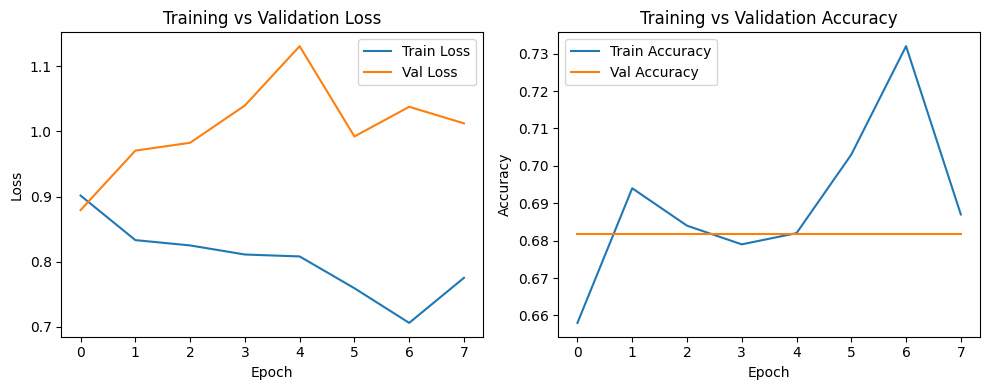

In [13]:
# Training curves
plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Val Loss")
plt.title("Training vs Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history["accuracy"], label="Train Accuracy")
plt.plot(history.history["val_accuracy"], label="Val Accuracy")
plt.title("Training vs Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

plt.tight_layout()
plt.show()


# Stap 5: pixel-level marking on 512×512 images
- Since the model is trained on 64×64 patches, pixel-level defect - localization is achieved using sliding-window inference.
- Each 512×512 image is scanned into overlapping 64×64 patches, which are classified using Stage-1 (Normal vs Defect) and Stage-2 (Defect Type).
- The patch predictions are projected back onto the original image to form class-wise probability heatmaps.
- These heatmaps are visualized as colored overlays, highlighting antisite, vacancy, and interstitial defect regions.


Loaded Stage-1: best_model_stage1_binary.keras
Loaded Stage-2: best_model_stage2_defects.keras
Found 512 images: 2

Processing: patch1_88282_512px.png  shape=(205, 208)


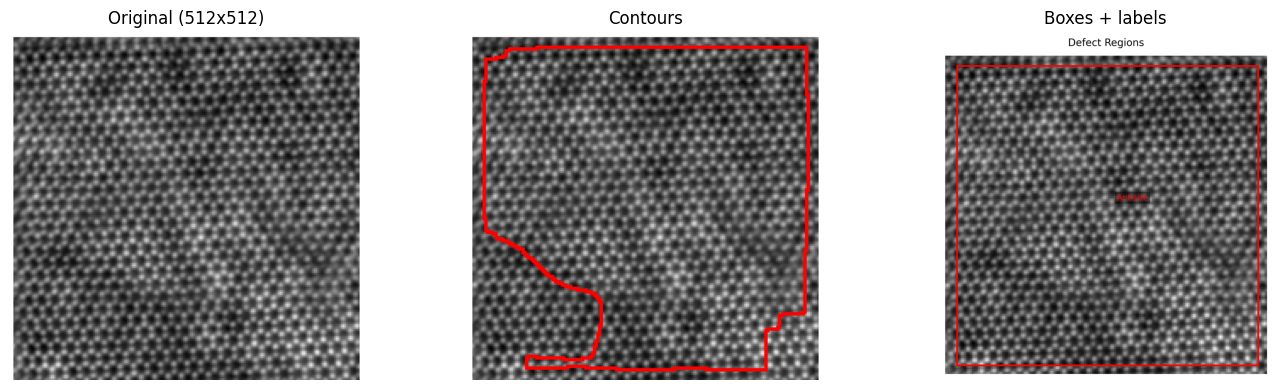


Processing: patch2_88282_512px.png  shape=(208, 211)


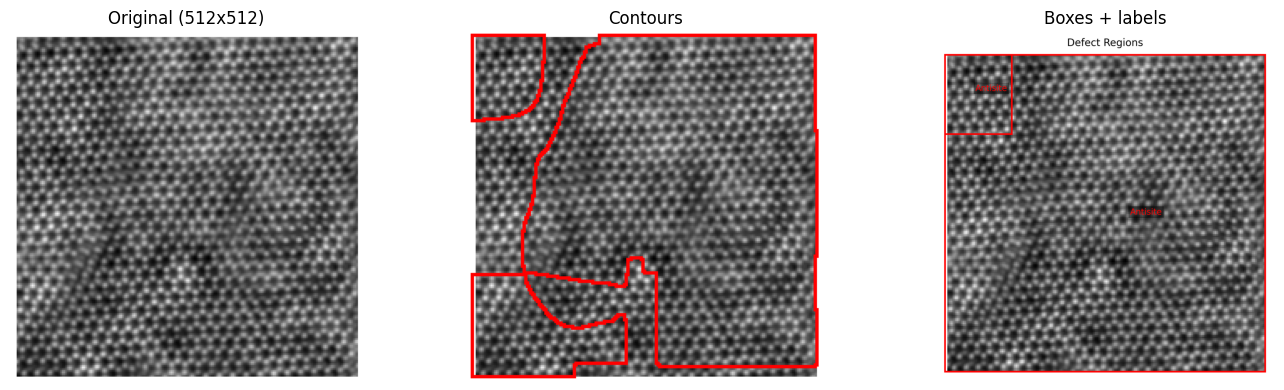


Done. Outputs saved to: /Users/karishmabegum/Desktop/Machine Learning/Team_Nanobot_Defect Classification/final_outputs


In [14]:
# CONFIG
PATCH_DIR   = "512x512_Patches"                 # 512x512 png's 
OUT_DIR     = "final_outputs"               # results are saved here
STAGE1_PATH = "best_model_stage1_binary.keras" # pre-trained stage 1 model
STAGE2_PATH = "best_model_stage2_defects.keras" # pre-trained stage 2 model

PATCH_SIZE  = 64
STRIDE      = 8           
TH_DEFECT   = 0.50         # Stage-1 threshold for "defect" patches
TH_MAP      = 0.40         # pixel threshold on final map
SMOOTH_SIGMA = 1.0         # Gaussian smoothing on heatmaps (0 disables)
MIN_REGION_AREA = 120      # remove tiny regions

# class names in same order as stage2 model output
CLASS_NAMES = ["Antisite", "Vacancy", "Interstitial"]

# Colors for contour/box overlays
COLORS = {
    "Antisite":     np.array([1.0, 0.0, 0.0]),  # red
    "Vacancy":      np.array([0.0, 1.0, 0.0]),  # green
    "Interstitial": np.array([0.0, 0.0, 1.0]),  # blue
}

os.makedirs(OUT_DIR, exist_ok=True)

#Preprocessing 
def read_grayscale_png(path):
    img = plt.imread(path)
    if img.ndim == 3:
        img = img[:, :, 0]
    return img.astype(np.float32)

def preprocess_two_channel(img_2d):
    spatial = img_2d / (np.max(img_2d) + 1e-8)
    spatial = ndi.gaussian_filter(spatial, sigma=0.5)

    fft = np.fft.fftshift(np.fft.fft2(spatial))
    fft_mag = np.log1p(np.abs(fft))
    fft_mag = fft_mag / (np.max(fft_mag) + 1e-8)

    return np.stack([spatial, fft_mag], axis=-1).astype(np.float32)

# Load the trained models
assert os.path.exists(STAGE1_PATH), f"Missing: {STAGE1_PATH}"
assert os.path.exists(STAGE2_PATH), f"Missing: {STAGE2_PATH}"

stage1 = tf.keras.models.load_model(STAGE1_PATH)   # outputs p(defect)
stage2 = tf.keras.models.load_model(STAGE2_PATH)   # outputs 3-way probs

print("Loaded Stage-1:", STAGE1_PATH)
print("Loaded Stage-2:", STAGE2_PATH)

# Patch blending window 
def make_gaussian_window(size=64, sigma=0.38):
    ax = np.linspace(-1, 1, size)
    xx, yy = np.meshgrid(ax, ax)
    g = np.exp(-(xx**2 + yy**2) / (2 * sigma**2))
    g = g / (g.max() + 1e-8)
    return g.astype(np.float32)

W_PATCH = make_gaussian_window(PATCH_SIZE, sigma=0.38)  # center-weight

# Sliding-window inference → probability heatmaps
def sliding_prob_maps(img_512):
    """
    Returns heat: (H,W,3) per-pixel probability for [Antisite, Vacancy, Interstitial]
    """
    H, W = img_512.shape
    acc = np.zeros((H, W, 3), dtype=np.float32)
    wsum = np.zeros((H, W, 1), dtype=np.float32)

    for y in range(0, H - PATCH_SIZE + 1, STRIDE):
        for x in range(0, W - PATCH_SIZE + 1, STRIDE):
            patch = img_512[y:y+PATCH_SIZE, x:x+PATCH_SIZE]
            xin = preprocess_two_channel(patch)[None, ...]

            p_def = float(stage1.predict(xin, verbose=0).ravel()[0])
            if p_def < TH_DEFECT:
                continue

            p3 = stage2.predict(xin, verbose=0).ravel().astype(np.float32)
            p3 = p3 * p_def  # weight by stage-1 confidence

            w = W_PATCH[:, :, None]
            acc[y:y+PATCH_SIZE, x:x+PATCH_SIZE, :] += w * p3[None, None, :]
            wsum[y:y+PATCH_SIZE, x:x+PATCH_SIZE, 0:1] += w

    heat = acc / np.maximum(wsum, 1e-8)

    if SMOOTH_SIGMA and SMOOTH_SIGMA > 0:
        for c in range(3):
            heat[:, :, c] = ndi.gaussian_filter(heat[:, :, c], sigma=SMOOTH_SIGMA)

    return heat

# Heatmap → label map + cleanup
"""Convert per-pixel class probs into a label map (0=background, 1..3=classes)."""
def probmaps_to_labelmap(heat, th_map):
    maxp = np.max(heat, axis=-1)
    arg = np.argmax(heat, axis=-1)              # 0..2
    label_map = (arg + 1).astype(np.uint8)      # 1..3
    label_map[maxp < th_map] = 0                # background
    return label_map, maxp

def clean_regions(mask, min_area):
    """Morphological cleanup + remove connected components smaller than min_area."""
    mask = mask.astype(bool)
    mask = ndi.binary_opening(mask, structure=np.ones((3,3)))
    mask = ndi.binary_closing(mask, structure=np.ones((5,5)))

    lab, n = ndi.label(mask)
    if n == 0:
        return mask.astype(np.uint8)

    sizes = ndi.sum(mask, lab, index=np.arange(1, n+1))
    keep = np.zeros(n+1, dtype=bool)
    keep[1:] = sizes >= min_area

    cleaned = keep[lab]
    return cleaned.astype(np.uint8)

def boundaries_from_mask(mask):
    """Extract thin boundary pixels for contour visualization."""
    mask = mask.astype(bool)
    dil = ndi.binary_dilation(mask, structure=np.ones((3,3)))
    ero = ndi.binary_erosion(mask, structure=np.ones((3,3)))
    return (dil ^ ero).astype(np.uint8)

# Visualization
def save_contour_overlay(img, masks, out_path):
    """Save original image with thin colored contours (no filled regions)."""
    base = img.astype(np.float32)
    base = img.astype(np.float32)
    base = (base - base.min()) / (base.max() - base.min() + 1e-8)

    rgb = np.stack([base, base, base], axis=-1)

    for cname in CLASS_NAMES:
        b = boundaries_from_mask(masks[cname])
        rgb[b.astype(bool)] = COLORS[cname]  # boundary only

    plt.imsave(out_path, np.clip(rgb, 0, 1))

def save_boxes_and_labels(img, masks, out_path, min_area=120):
    """Save original image with bounding boxes + text labels for each region."""
    fig, ax = plt.subplots(1, 1, figsize=(7,7))
    ax.imshow(img, cmap="gray")
    ax.set_title("Defect Regions")
    ax.axis("off")

    for cname in CLASS_NAMES:
        mask = masks[cname].astype(bool)
        lab, n = ndi.label(mask)
        if n == 0:
            continue

        sizes = ndi.sum(mask, lab, index=np.arange(1, n+1))
        for ridx, area in enumerate(sizes, start=1):
            if area < min_area:
                continue

            sl = ndi.find_objects(lab == ridx)[0]
            y0, y1 = sl[0].start, sl[0].stop
            x0, x1 = sl[1].start, sl[1].stop

            cy, cx = ndi.center_of_mass(mask, lab, ridx)

            rect = Rectangle((x0, y0), (x1-x0), (y1-y0),
                             fill=False, linewidth=2, edgecolor=COLORS[cname])
            ax.add_patch(rect)

            ax.text(cx, cy, cname,
                    color=COLORS[cname],
                    fontsize=10,
                    bbox=dict(facecolor="black", alpha=0.45, pad=2, edgecolor="none"))

    fig.savefig(out_path, dpi=250, bbox_inches="tight")
    plt.close(fig)

# Run localization on all 512×512 images
files = sorted(glob.glob(os.path.join(PATCH_DIR, "*.png")))
print("Found 512 images:", len(files))
assert len(files) > 0, f"No PNGs found in {PATCH_DIR}"

for path in files:
    name = os.path.splitext(os.path.basename(path))[0]
    img = read_grayscale_png(path)
    print(f"\nProcessing: {name}.png  shape={img.shape}")

    heat = sliding_prob_maps(img)
    label_map, maxp = probmaps_to_labelmap(heat, TH_MAP)

   # Build and clean per-class masks
    masks = {}
    for idx, cname in enumerate(CLASS_NAMES, start=1):
        m = (label_map == idx).astype(np.uint8)
        m = clean_regions(m, min_area=MIN_REGION_AREA)
        masks[cname] = m

    # save confidence map 
    plt.imsave(os.path.join(OUT_DIR, f"{name}_maxprob.png"), maxp, cmap="magma", vmin=0, vmax=1)

    # save masks (optional)
    for cname in CLASS_NAMES:
        plt.imsave(os.path.join(OUT_DIR, f"{name}_{cname}_mask.png"), masks[cname], cmap="gray")

    # save contour overlay 
    contour_path = os.path.join(OUT_DIR, f"{name}_contour.png")
    save_contour_overlay(img, masks, contour_path)

    # save boxed + labeled overlay
    boxed_path = os.path.join(OUT_DIR, f"{name}_boxed.png")
    save_boxes_and_labels(img, masks, boxed_path, min_area=MIN_REGION_AREA)

    # quick preview in notebook
    plt.figure(figsize=(14,4))
    plt.subplot(1,3,1); plt.title("Original (512x512)"); plt.imshow(img, cmap="gray"); plt.axis("off")
    plt.subplot(1,3,2); plt.title("Contours"); plt.imshow(plt.imread(contour_path)); plt.axis("off")
    plt.subplot(1,3,3); plt.title("Boxes + labels"); plt.imshow(plt.imread(boxed_path)); plt.axis("off")
    plt.tight_layout()
    plt.show()

print("\nDone. Outputs saved to:", os.path.abspath(OUT_DIR))



**Result Explanation:** Sliding-window inference on 512×512 images successfully localized defect regions by
aggregating overlapping 64×64 patch predictions into smooth probability maps.
- The contour overlays highlight spatially consistent defect boundaries, while bounding
boxes provide coarse region-level localization and labeling. 
- This demonstrates that patch-trained classifiers can be effectively extended to large images without explicit pixel-level supervision.


# Step 6: Practical Impact and Industry Relevance

- This project demonstrates how deep learning can be applied to **automated defect detection
and localization** in structured scientific images, a task that is traditionally performed
through manual inspection or rule-based image processing. By learning defect signatures
directly from data, the pipeline reduces dependence on handcrafted thresholds and expert
visual screening, which are time-consuming and subjective.

- In manufacturing and materials science workflows, the two-stage design enables **early
screening of large datasets**, where Stage 1 filters normal regions and Stage 2 focuses
computational resources on likely defects. This significantly improves throughput when
analyzing high-resolution microscopy images and allows experts to prioritize regions that
require deeper investigation.

- The sliding-window localization approach produces **interpretable visual outputs** (contours
and bounding boxes) rather than only class labels, making the system suitable as a
decision-support tool. Engineers and researchers can visually verify model predictions,
build trust in the system, and integrate it into quality control or failure analysis
pipelines.

- More broadly, this work illustrates a scalable framework that can be adapted to other
periodic or structured imaging domains—such as semiconductor inspection, thin-film
analysis, and crystal defect characterization where labeled pixel-level data is scarce
but patch-level annotations are feasible.

# Step 7: Future Work

- This pipeline can be upgraded by replacing sliding-window inference with an end-to-end
segmentation model, enabling direct pixel-level defect prediction without patch stitching.
Architectures such as U-Net, Attention U-Net, or DeepLabV3+ are well-suited for learning
fine-grained spatial boundaries in lattice images.

- Performance on rare defect types can be improved by better class balancing, focal loss,
or class-aware sampling strategies. Incorporating multi-scale feature extraction
(e.g., Feature Pyramid Networks) and attention mechanisms could help the model focus on
subtle lattice disruptions. Finally, training on data from varied imaging conditions and
adding uncertainty estimation (e.g., Monte Carlo Dropout or Bayesian CNNs) would improve
robustness and real-world applicability.

 



# Step 8: Key Learnings

- 1) Why a two-stage pipeline works better than a single multi-class model
A key learning from this project is that **decomposing the problem** into two simpler tasks can be more effective than training one model to solve everything at once. In a direct 4-class setting (Normal + 3 defect types), the model must simultaneously learn (i) whether a patch is abnormal and (ii) which defect type it is. In practice, this creates two major issues: **class imbalance** (Normal dominates) and **decision coupling** (the model can confuse defect type features with “abnormality” features).  
By separating the task into **Stage 1: Normal vs Defect** and **Stage 2: defect-type classification**, the network learns a cleaner representation. Stage 1 focuses on detecting *any deviation from lattice regularity*, while Stage 2 focuses on *fine-grained differences among defect classes*. This staged design also improves interpretability because we can analyze whether errors arise from detection (Stage 1) or from classification (Stage 2).

- 2) Understanding the trade-off between defect recall and defect precision
From the Stage 1 confusion matrix, it becomes clear that the model can behave **conservatively**, often predicting “Normal” unless it sees strong evidence of a defect. This produces fewer false positives (good for filtering) but increases false negatives (missed subtle defects).  
This taught an important practical lesson: in pipelines, the “best” operating point depends on the downstream stage. If Stage 1 is too permissive, Stage 2 gets flooded with normal patches and performance collapses. If Stage 1 is too strict, Stage 2 never sees many real defects. Therefore, **threshold selection (TH_DEFECT)** is not a cosmetic choice; it is a core system-level design decision. In real deployments, this threshold should be tuned using ROC/PR curves based on the desired balance between missed defects and false alarms.

- 3) Why frequency-domain features (FFT) help on periodic lattices
Another strong learning is the value of **domain-aware representations**. Lattice images are inherently periodic, so many defect signatures appear not only as localized spatial disturbances but also as changes in the periodic frequency content.  
Using a second channel based on **FFT magnitude** helps the model detect disruptions in periodicity and symmetry. Even when a defect is subtle in the spatial image, it may shift energy across frequency components. Conceptually, the spatial channel answers “what is the local intensity pattern?”, while the FFT channel answers “how has the lattice periodic structure changed?”. This dual view improves robustness, especially when defect contrast is low.

- 4) The role of preprocessing in stabilizing learning
This project reinforced that deep learning performance is strongly influenced by preprocessing choices. Normalizing the spatial channel to a consistent range reduces variation due to brightness scaling. Light Gaussian smoothing reduces high-frequency noise that can dominate early convolution filters. Log-scaling FFT magnitude compresses large spectral peaks so the FFT channel becomes numerically stable and informative.  
The key lesson is that preprocessing is not simply “cleanup”; it encodes assumptions about what variations matter and what should be ignored. For scientific imaging problems, careful preprocessing often contributes as much as architecture selection.

-  5) Class imbalance is not just a dataset issue—it shapes model behavior
Stage 2 results show a strong tendency to predict the dominant class (Antisite), effectively collapsing minority classes into the majority. This is a direct consequence of imbalance: the optimizer minimizes loss by being correct on the most frequent class, especially when minority classes are rare and visually subtle.  
This taught that class imbalance must be addressed explicitly through strategies such as **oversampling**, **class weights**, or **focal loss**, and that evaluation must look beyond accuracy. In defect classification, a high overall accuracy can still hide complete failure on rare defect types, which is unacceptable in many scientific or manufacturing contexts.

- 6) Why augmentation must be physically meaningful
Augmentation improved stability but also highlighted a subtle point: augmentations must preserve defect identity. Flips and 90° rotations are reasonable because lattice symmetry often makes orientation irrelevant, while small Gaussian noise improves robustness to imaging noise.  
The learning is that “more augmentation” is not always better. Aggressive augmentations (heavy blur, large intensity shifts, elastic warps) might destroy defect cues or create unrealistic physics, which can hurt generalization. For scientific applications, augmentation should be guided by what transformations are physically plausible.

- 7) Sliding-window localization is a practical bridge between classification and segmentation
Even though the models were trained only for patch-level labels, sliding-window inference allowed meaningful pixel-level localization. The core idea is that a classifier can be repurposed as a weak local detector by evaluating it across overlapping windows and projecting predictions back into image space.  
A major learning here is that the quality of localization depends on *engineering details*: stride size controls resolution, patch blending reduces seams, smoothing improves spatial consistency, and morphological cleanup removes noise. This reinforces that successful localization is not purely a modeling problem; it is a pipeline design problem.

- 8) Why Gaussian patch blending reduces block artifacts
When patch predictions are stitched directly, boundary seams appear because each patch is treated equally, even at edges where predictions are less reliable. By weighting patch contributions with a **Gaussian window** (center-weighted), the system emphasizes the most trustworthy region of each patch.  
This technique significantly improves map smoothness and reduces checkerboard artifacts. The learning is that blending strategies borrowed from signal processing can materially improve neural inference outputs, especially when using sliding-window approaches.

- 9) Post-processing determines whether predictions become usable outputs
Raw probability maps are not immediately useful to a user. Converting them into masks, removing small noisy regions, extracting boundaries, and producing bounding boxes turns predictions into interpretable outputs.  
This demonstrates that in applied ML, success is measured not only by accuracy but by the ability to produce outputs that are actionable and visually meaningful. Morphological opening/closing and minimum-area filtering provide robustness against isolated false positives.

- 10) Evaluation must match the scientific goal, not just ML conventions
This project emphasized that “accuracy” is often insufficient. For Stage 1, defect recall might matter more than accuracy depending on application. For Stage 2, per-class precision/recall matters because minority defect detection is critical. For localization, qualitative visualization and region consistency are essential because the objective is spatial interpretability, not only class prediction.  
A practical takeaway is that evaluation metrics should be chosen based on the scientific question: detection reliability, correct defect typing, and stable localization.

- 11) Generalization is the central challenge in scientific imaging
The results suggest that even when training loss decreases, validation metrics may plateau due to domain shift: changes in intensity, lattice spacing, noise statistics, or simulation conditions. This reinforces that robust defect detection requires diversity in training data and potentially domain adaptation techniques.  
The learning is that building models for scientific imaging is often less about fitting the training data and more about ensuring the representation is stable across different acquisition conditions.

- 12) System-level thinking matters more than any single model choice
Finally, the biggest learning is that this is not “just a CNN problem.” The final performance depends on coordinated design across preprocessing, thresholding, sampling, augmentation, architecture, inference scanning, blending, and post-processing.  
This project demonstrates an important research mindset: improvements come not only from deeper networks but from understanding the entire pipeline as a system and identifying where errors originate (Stage 1 filtering vs Stage 2 confusion vs localization artifacts).

- Overall, this work shows how patch-level defect learning can be extended to large-scale localization using a carefully engineered pipeline, and highlights the core research challenges: imbalance, subtle class boundaries, and generalization across imaging conditions.
